In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # operating system 
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from typing import Tuple
import time
import pickle
from functools import wraps
from matplotlib import pyplot as plt  
%matplotlib inline

In [2]:
CSV_PATH = '/kaggle/input/cars-pose/car_imgs_4000.csv'
IMAGE_FOLDER_PATH = '/kaggle/input/cars-pose/imgs'
IMG_SIZE = (224, 224) 

In [3]:
def time_execution(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()  # start time
        result = func(*args, **kwargs)  # Call the actual function
        end_time = time.time()  # end time
        execution_time = end_time - start_time  
        print(f"Execution time of {func.__name__}: {execution_time:.4f} seconds")
        return result  # Return the result of the function call
    return wrapper

In [4]:
def load_and_preprocess_image(path: str, img_size: Tuple[int, int], label: Tuple[float, float]):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

@time_execution
def load_data(csv_file_path: str, images_folder: str, img_size: Tuple[int, int] = IMG_SIZE, test_size: float = 0.2, batch_size = 32):
    # Load the CSV file
    data = pd.read_csv(csv_file_path)
    
    # Shuffle the data
    data = data.sample(frac=1).reset_index(drop=True)
    
    # Extract filenames and labels
    filenames = data['filename'].values
    labels = data[['perspective_score_hood', 'perspective_score_backdoor_left']].values
    
    # Convert filenames to full paths
    full_paths = [os.path.join(images_folder, fname) for fname in filenames]
    
    # Split into training and testing sets
    train_paths, test_paths, train_labels, test_labels = train_test_split(full_paths, labels, test_size=test_size, random_state=42)
    
    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    train_dataset = train_dataset.map(lambda path, label: load_and_preprocess_image(path, img_size, label), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    test_dataset = test_dataset.map(lambda path, label: load_and_preprocess_image(path, img_size, label), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return train_dataset, test_dataset, test_paths
train_dataset, test_dataset, test_paths = load_data(CSV_PATH, IMAGE_FOLDER_PATH)

Execution time of load_data: 0.8285 seconds


In [5]:
# Iterate through a few batches in the train dataset to see some samples
for batch in train_dataset.take(1):
    images, labels = batch
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels: {labels.shape}")

Batch of images shape: (32, 224, 224, 3)
Batch of labels: (32, 2)


In [6]:
import tensorflow as tf
from typing import Tuple

def split_train_dataset(
                train_dataset: tf.data.Dataset, 
                val_split: float = 0.1,
                prefetch_buffer_size: int = tf.data.experimental.AUTOTUNE
                ) -> Tuple[tf.data.Dataset, tf.data.Dataset]:

    # Calculate dataset size
    dataset_size = sum(1 for _ in train_dataset)
    
    # Calculate sizes
    val_size = int(val_split * dataset_size)
    
    # Shuffle the dataset if not already shuffled
    train_dataset = train_dataset.shuffle(buffer_size=dataset_size, seed=42)
    
    # Split the dataset into new training and validation datasets
    val_dataset = train_dataset.take(val_size)
    train_dataset = train_dataset.skip(val_size)
    
    # Prefetch both datasets to improve performance
    train_dataset = train_dataset.prefetch(buffer_size=prefetch_buffer_size)
    val_dataset = val_dataset.prefetch(buffer_size=prefetch_buffer_size)
    
    return train_dataset, val_dataset

In [7]:
def get_data_augmentation_layer() -> tf.keras.Sequential:
    return tf.keras.Sequential([
        #Rescaling(1./255),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ])

In [8]:
def build_model(input_shape: Tuple[int, int, int] = (224, 224, 3)) -> tf.keras.Model:
    inputs = Input(shape=input_shape)
    
    # Apply the data augmentation layer
    x = get_data_augmentation_layer()(inputs)
    
    # Continue with the rest of the layers
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(x)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(2, activation='linear')(x)  # 2 outputs for the two perspective scores
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9)
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                  loss='mean_squared_error', 
                  metrics=['mae'])
    return model

In [9]:
model = build_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 454,722 (1.73 MB)

 Trainable params: 454,722 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def get_callbacks(model_save_path: str):
    # Save the best model during training
    checkpoint_callback = ModelCheckpoint(
        model_save_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    # Stop training early if no improvement
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
    
    # Reduce learning rate when a metric has stopped improving
    #reduce_lr_callback = ReduceLROnPlateau(
       # monitor='val_loss',
       # factor=0.5,
       # patience=5,
     #   verbose=1
    #)
    
    return [checkpoint_callback, early_stopping_callback]

In [11]:
@time_execution
def train_model(model: tf.keras.Model, train_dataset: tf.data.Dataset, val_dataset: tf.data.Dataset, callbacks, epochs: int = 1000):
    history =  model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks = callbacks)
    return history 

In [12]:
train_dataset_final, val_dataset= split_train_dataset(train_dataset, val_split=0.3)
model = build_model()
# Assuming train_dataset is your training dataset
#display_callback = DisplayCallback(model_instance=model, dataset=train_dataset, frequency=1)
model_save_path = "./veihcle_pose_predictior_linear_final.keras"
callbacks = get_callbacks(model_save_path)
#callbacks.append(display_callback)

In [13]:
history = train_model(model, train_dataset_final, val_dataset, callbacks)

Epoch 1/1000
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.3567 - mae: 0.3264
Epoch 1: val_loss improved from inf to 0.16339, saving model to ./veihcle_pose_predictior_linear_final.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - loss: 1.3382 - mae: 0.3266 - val_loss: 0.1634 - val_mae: 0.3261
Epoch 2/1000
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1581 - mae: 0.3381
Epoch 2: val_loss improved from 0.16339 to 0.14483, saving model to ./veihcle_pose_predictior_linear_final.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.1579 - mae: 0.3380 - val_loss: 0.1448 - val_mae: 0.3293
Epoch 3/1000
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1408 - mae: 0.3305
Epoch 3: val_loss improved from 0.14483 to 0.14336, saving model to ./veihcle_pose_predictior_linear_final.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.1408 - mae: 0.3305 - val_loss: 0.1434 - val_mae: 0.3519
Epoch 4/1000
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1405 - mae: 0.3345
Epoch 4: val_loss 

In [11]:
def save_dict_to_file(dictionary: dict, file_path: str) -> None:
    with open(file_path, 'wb') as file:
        pickle.dump(dictionary, file)
    print(f"Dictionary saved to {file_path}")
    
def load_dict_from_file(file_path: str) -> dict:
    with open(file_path, 'rb') as file:
        dictionary = pickle.load(file)
    return dictionary

#dump_dict_simple_cnn = save_dict_to_file(history, './lightcnn_history_dict')
#history_loaded_simple_cnn = load_dict_from_file('/kaggle/working/lightcnn_history_dict')
history_loaded_simple_cnn = load_dict_from_file('/kaggle/input/model-output/lightcnn_history_dict')

In [12]:
def plot_training_history(history:dict)-> None:
    # Plot training & validation loss values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    
    # Plot training & validation MAE values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

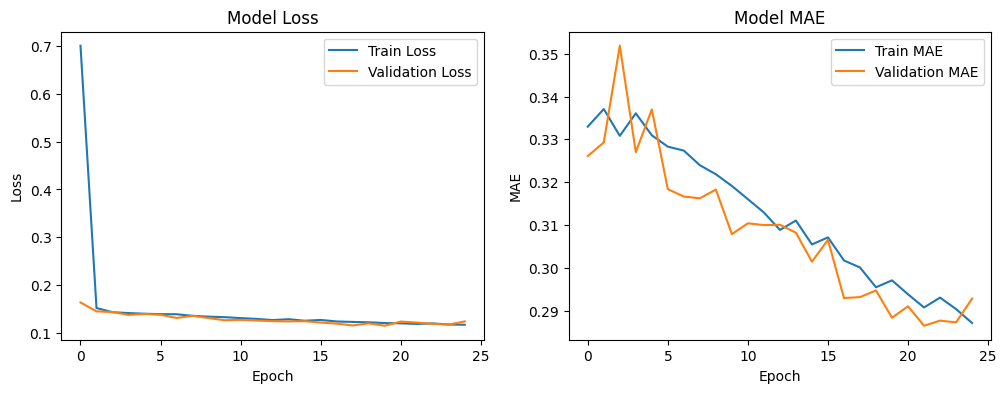

In [13]:
plot_training_history(history_loaded_simple_cnn)

In [18]:
def load_trained_model(model_save_path: str) -> tf.keras.Model:
    model = tf.keras.models.load_model(model_save_path)
    return model

#model_save_path = "/kaggle/input/trained-model/veihcle_pose_predictior_linear_final.keras"
model_save_path = "/kaggle/input/model-output/veihcle_pose_predictior_linear_final.keras"
model_loaded = load_trained_model(model_save_path)
model_loaded.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,364,167 (5.20 MB)

 Trainable params: 454,722 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 909,445 (3.47 MB)

In [20]:
model = model_loaded

In [21]:
def evaluate_model_on_test(model: tf.keras.Model, test_dataset: tf.data.Dataset)-> Tuple[float, float]:
    # Evaluate the model on the test data
    test_loss, test_mae = model.evaluate(test_dataset)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    return test_loss, test_mae
test_loss, test_mae = evaluate_model_on_test(model, test_dataset)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1201 - mae: 0.2950
Test Loss: 0.1174
Test MAE: 0.2907


In [19]:
#test_loss, test_mae = evaluate_model_on_test(model, test_dataset) ## with vgg16 model 

In [22]:
import numpy as np

def predict_on_test_set(model: tf.keras.Model, test_dataset: tf.data.Dataset)->Tuple[float, float]:
    predictions = []
    true_values = []

    for batch in test_dataset:
        images, labels = batch
        preds = model.predict(images, verbose=0)
        predictions.append(preds)
        true_values.append(labels.numpy())

    predictions = np.concatenate(predictions, axis=0)
    true_values = np.concatenate(true_values, axis=0)

    return predictions, true_values
predictions, true_values = predict_on_test_set(model, test_dataset)

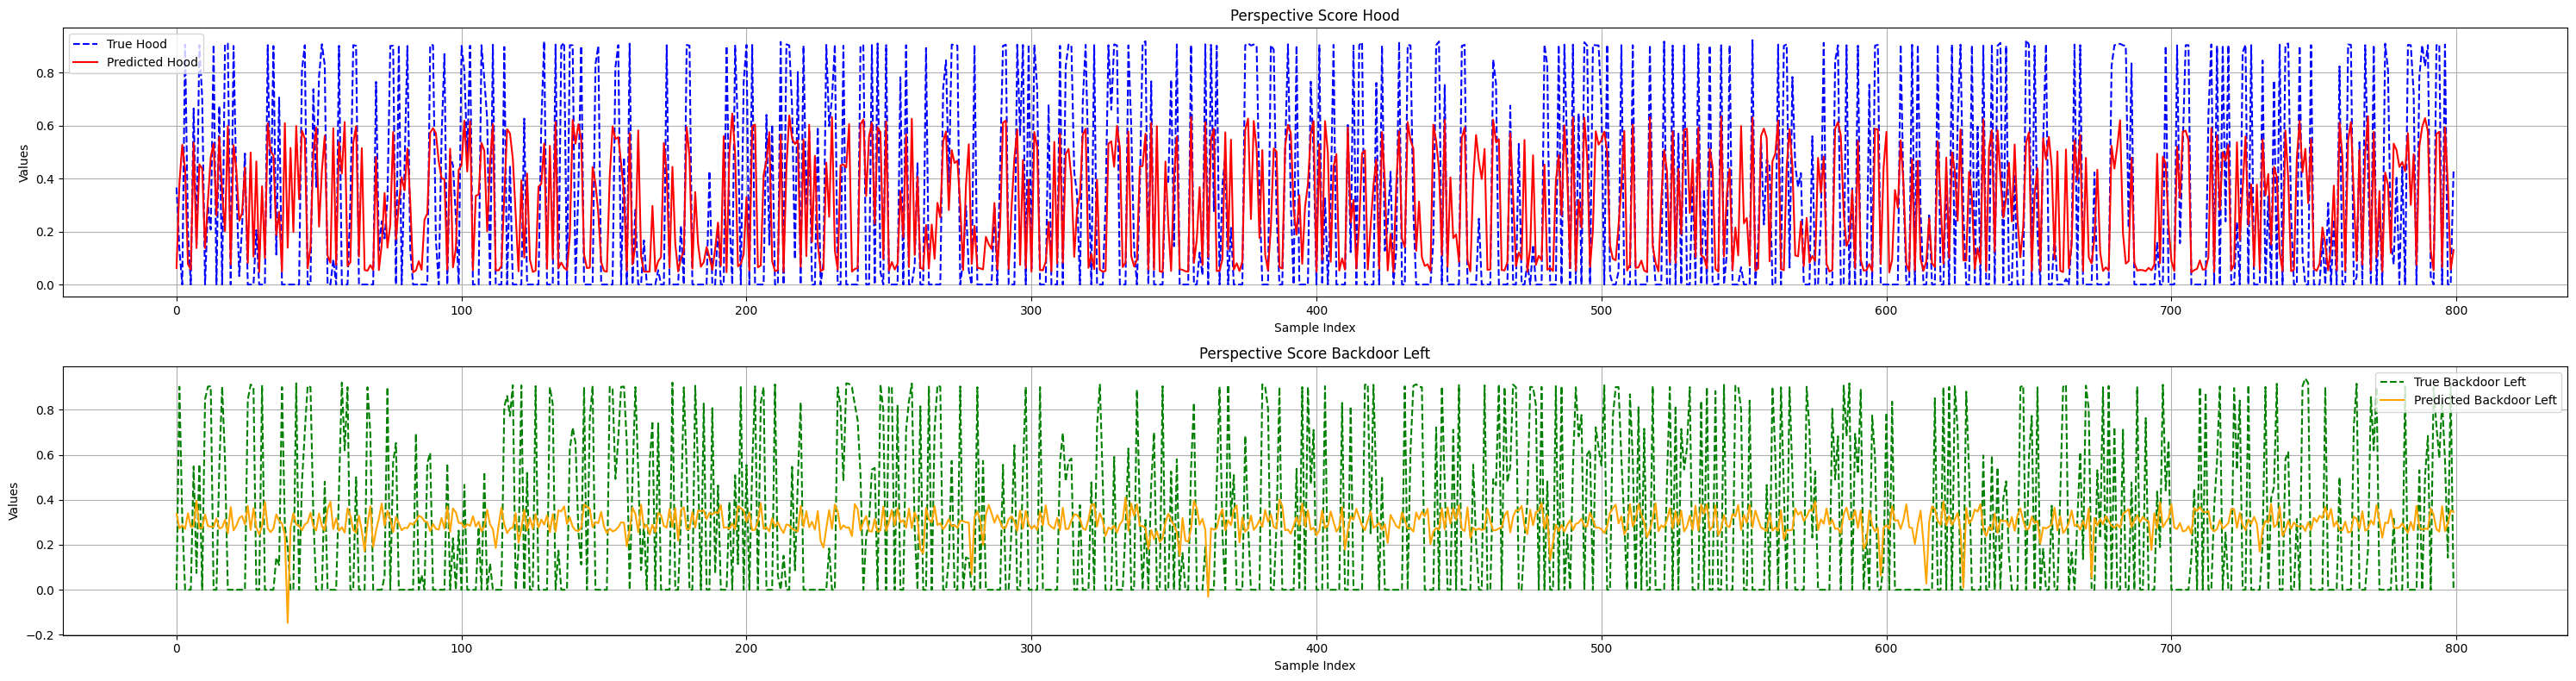

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_true_vs_pred(true_values: np.array, predicted_values: np.array , title: str, 
                      true_label='True', pred_label='Predicted', color_true='blue', color_pred='red')->None:
    plt.plot(true_values, label=f'{true_label}', linestyle='--', color=color_true)
    plt.plot(predicted_values, label=f'{pred_label}', linestyle='-', color=color_pred)
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)

def plot_predictions_vs_true_values(model: tf.keras.Model, test_dataset: tf.data.Dataset):
    # Collect all images and true values from the test dataset
    all_images = []
    all_true_values = []
    
    for images, labels in test_dataset.unbatch():
        all_images.append(images.numpy())
        all_true_values.append(labels.numpy())
    
    # Convert lists to numpy arrays
    all_images = np.array(all_images)
    all_true_values = np.array(all_true_values)
    
    # Get predictions from the model
    predictions = model.predict(all_images, verbose=0)  # Suppress batch size and timing output
    
    # Plotting
    plt.figure(figsize=(30, 8))
    
    # Plot for Perspective Score Hood
    plt.subplot(2, 1, 1)
    plot_true_vs_pred(all_true_values[:, 0], predictions[:, 0], title='Perspective Score Hood', true_label='True Hood', pred_label='Predicted Hood', color_true='blue', color_pred='red')
    
    # Plot for Perspective Score Backdoor Left
    plt.subplot(2, 1, 2)
    plot_true_vs_pred(all_true_values[:, 1], predictions[:, 1], title='Perspective Score Backdoor Left', true_label='True Backdoor Left', pred_label='Predicted Backdoor Left', color_true='green', color_pred='orange')
    
    plt.tight_layout()
    plt.show()

# Usage example
plot_predictions_vs_true_values(model, test_dataset)

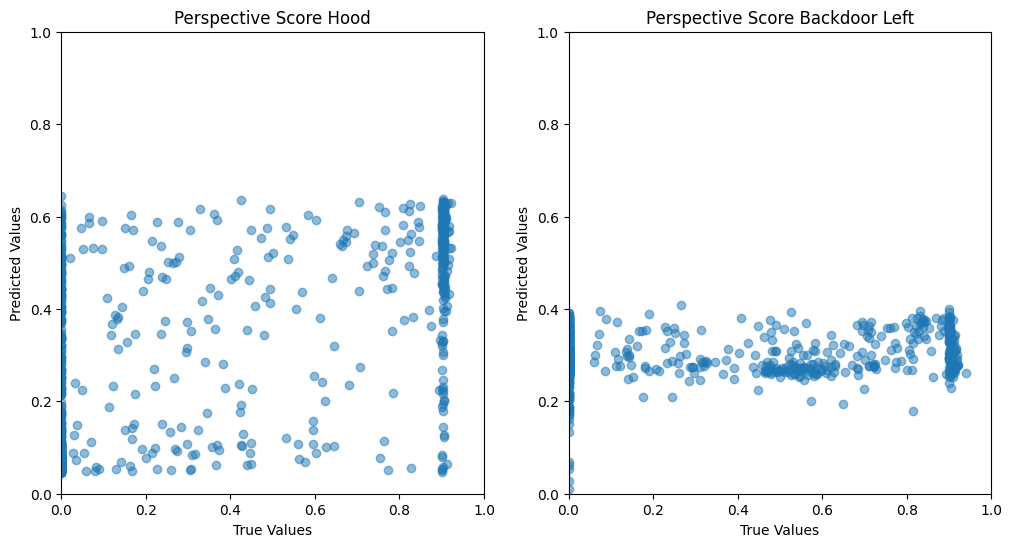

In [24]:
def plot_predictions_vs_true(predictions: np.array, true_values: np.array):
    plt.figure(figsize=(12, 6))
    # Perspective Score Hood
    plt.subplot(1, 2, 1)
    plt.scatter(true_values[:, 0], predictions[:, 0], alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Perspective Score Hood')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # Perspective Score Backdoor Left
    plt.subplot(1, 2, 2)
    plt.scatter(true_values[:, 1], predictions[:, 1], alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Perspective Score Backdoor Left')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()
plot_predictions_vs_true(predictions, true_values)

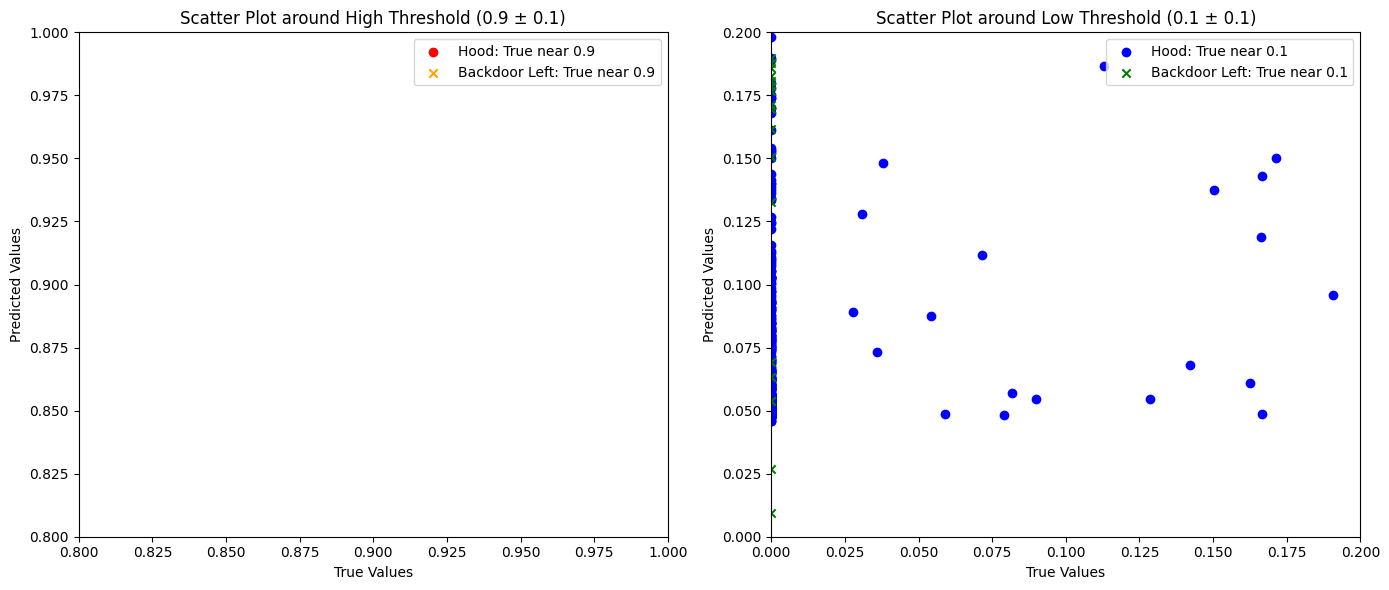

In [25]:
def visualize_extreme_predictions(
    model: tf.keras.Model, 
    test_dataset: tf.data.Dataset, 
    high_threshold: float = 0.9, 
    low_threshold: float = 0.1, 
    margin: float = 0.1
) -> None:
    # Get predictions and true values using the provided function
    predictions, true_values = predict_on_test_set(model, test_dataset)
    
    # Separate the scores for different columns (assuming 2 columns: hood and backdoor left)
    true_hood = true_values[:, 0]
    pred_hood = predictions[:, 0]
    true_backdoor_left = true_values[:, 1]
    pred_backdoor_left = predictions[:, 1]

    # Filter for values around the high_threshold ± margin
    high_mask_hood = (true_hood >= high_threshold - margin) & (true_hood <= high_threshold + margin)
    high_mask_backdoor_left = (true_backdoor_left >= high_threshold - margin) & (true_backdoor_left <= high_threshold + margin)
    
    # Filter for values around the low_threshold ± margin
    low_mask_hood = (true_hood >= low_threshold - margin) & (true_hood <= low_threshold + margin)
    low_mask_backdoor_left = (true_backdoor_left >= low_threshold - margin) & (true_backdoor_left <= low_threshold + margin)
    
    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot high threshold values
    ax[0].scatter(true_hood[high_mask_hood], pred_hood[high_mask_hood], color='red', marker='o', label='Hood: True near {0}'.format(high_threshold))
    ax[0].scatter(true_backdoor_left[high_mask_backdoor_left], pred_backdoor_left[high_mask_backdoor_left], color='orange', marker='x', label='Backdoor Left: True near {0}'.format(high_threshold))
    ax[0].set_xlabel('True Values')
    ax[0].set_ylabel('Predicted Values')
    ax[0].set_title(f'Scatter Plot around High Threshold ({high_threshold} ± {margin})')
    ax[0].legend()
    ax[0].set_xlim([high_threshold - margin, high_threshold + margin])
    ax[0].set_ylim([high_threshold - margin, high_threshold + margin])

    # Plot low threshold values
    ax[1].scatter(true_hood[low_mask_hood], pred_hood[low_mask_hood], color='blue', marker='o', label='Hood: True near {0}'.format(low_threshold))
    ax[1].scatter(true_backdoor_left[low_mask_backdoor_left], pred_backdoor_left[low_mask_backdoor_left], color='green', marker='x', label='Backdoor Left: True near {0}'.format(low_threshold))
    ax[1].set_xlabel('True Values')
    ax[1].set_ylabel('Predicted Values')
    ax[1].set_title(f'Scatter Plot around Low Threshold ({low_threshold} ± {margin})')
    ax[1].legend()
    ax[1].set_xlim([low_threshold - margin, low_threshold + margin])
    ax[1].set_ylim([low_threshold - margin, low_threshold + margin])

    # Show the plots
    plt.tight_layout()
    plt.show()

visualize_extreme_predictions(model, test_dataset, high_threshold=0.9, low_threshold=0.1, margin=0.1)

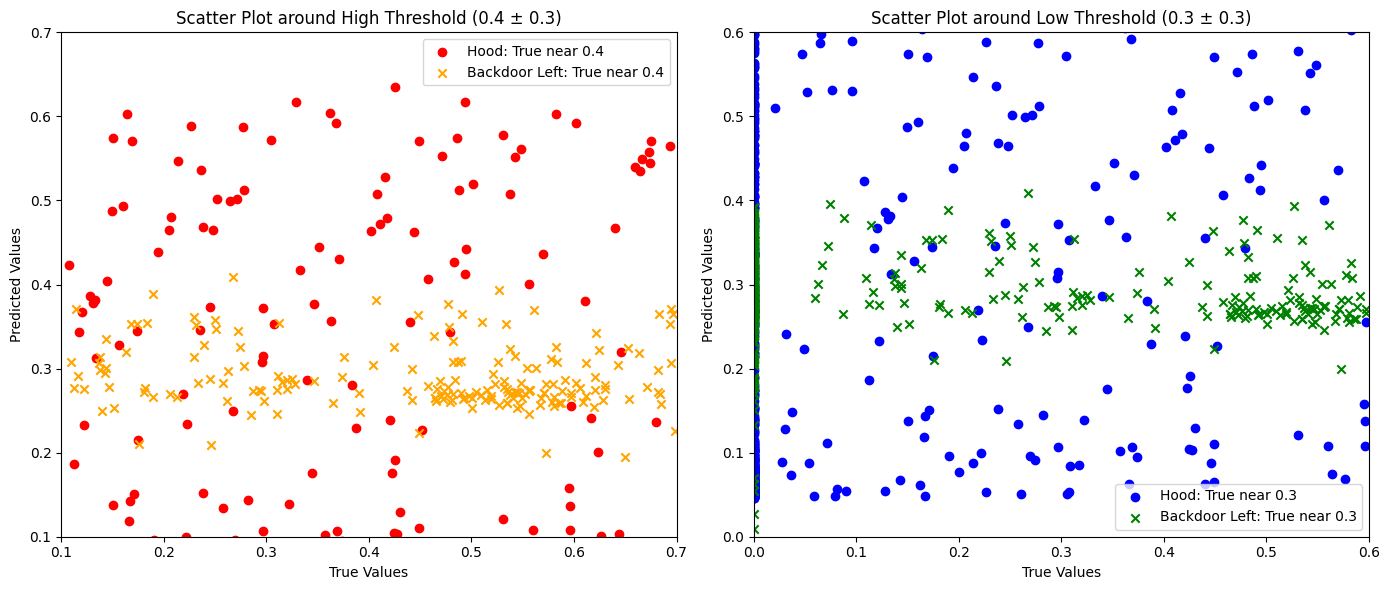

In [26]:
visualize_extreme_predictions(model, test_dataset, high_threshold=0.4, low_threshold=0.3, margin=0.3)

In [27]:
def analyze_errors(predictions, true_values):
    errors = np.abs(predictions - true_values)
    
    # Print out basic statistics about the errors
    print(f"Mean Absolute Error Hood: {np.mean(errors[:, 0]):.4f}")
    print(f"Mean Absolute Error Backdoor Left: {np.mean(errors[:, 1]):.4f}")
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(errors[:, 0], bins=20, alpha=0.7, color='blue')
    plt.title('Error Distribution for Hood')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(errors[:, 1], bins=20, alpha=0.7, color='green')
    plt.title('Error Distribution for Backdoor Left')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    
    plt.show()

Mean Absolute Error Hood: 0.2487
Mean Absolute Error Backdoor Left: 0.3327


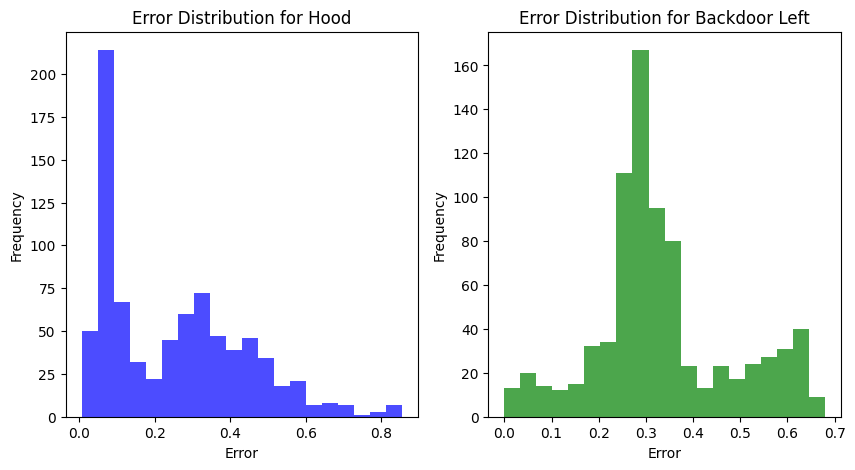

In [28]:
analyze_errors(predictions, true_values)

In [32]:
def plot_best_and_worst_predictions(model, test_dataset, num_images=7):
    predictions, true_values = predict_on_test_set(model, test_dataset)
    errors = np.abs(predictions - true_values)
    total_errors = np.mean(errors, axis=1)  # Average error per sample
    
    # Sort by total error
    sorted_indices = np.argsort(total_errors)
    
    # Get best and worst indices
    best_indices = sorted_indices[:num_images]
    worst_indices = sorted_indices[-num_images:]
    
    # Plotting
    plt.figure(figsize=(20,6))
    
    # Best Predictions
    for i, idx in enumerate(best_indices):
        plt.subplot(2, num_images, i + 1)
        image, label = test_dataset.unbatch().skip(idx).take(1).get_single_element()
        plt.imshow(image.numpy())
        plt.title(f"{np.round(label.numpy(), 2)},{np.round(predictions[idx], 2)}")
        plt.axis('off')
    
    # Worst Predictions
    for i, idx in enumerate(worst_indices):
        plt.subplot(2, num_images, num_images + i + 1)
        image, label = test_dataset.unbatch().skip(idx).take(1).get_single_element()
        plt.imshow(image.numpy())
        plt.title(f"{np.round(label.numpy(), 2)},{np.round(predictions[idx], 2)}")
        plt.axis('off')
    
    plt.suptitle("Top Row: Best Predictions[True,Pred] | Bottom Row: Worst Predictions[True,Pred]")
    plt.show()

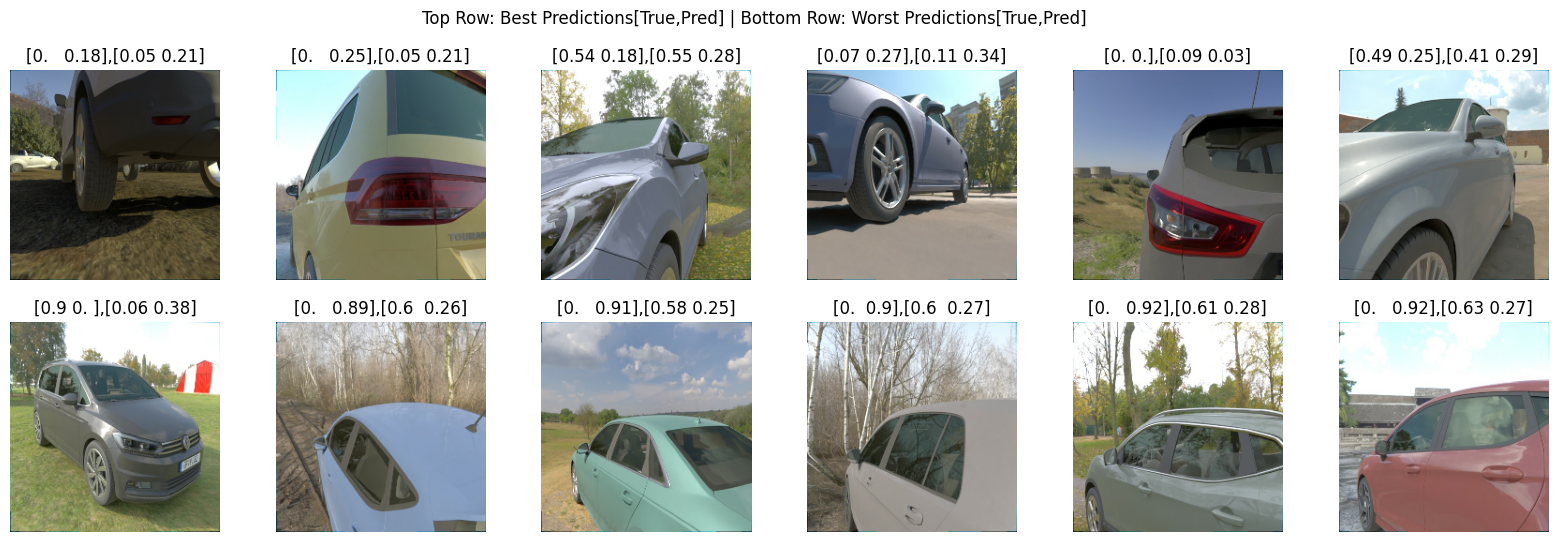

In [30]:
plot_best_and_worst_predictions(model, test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


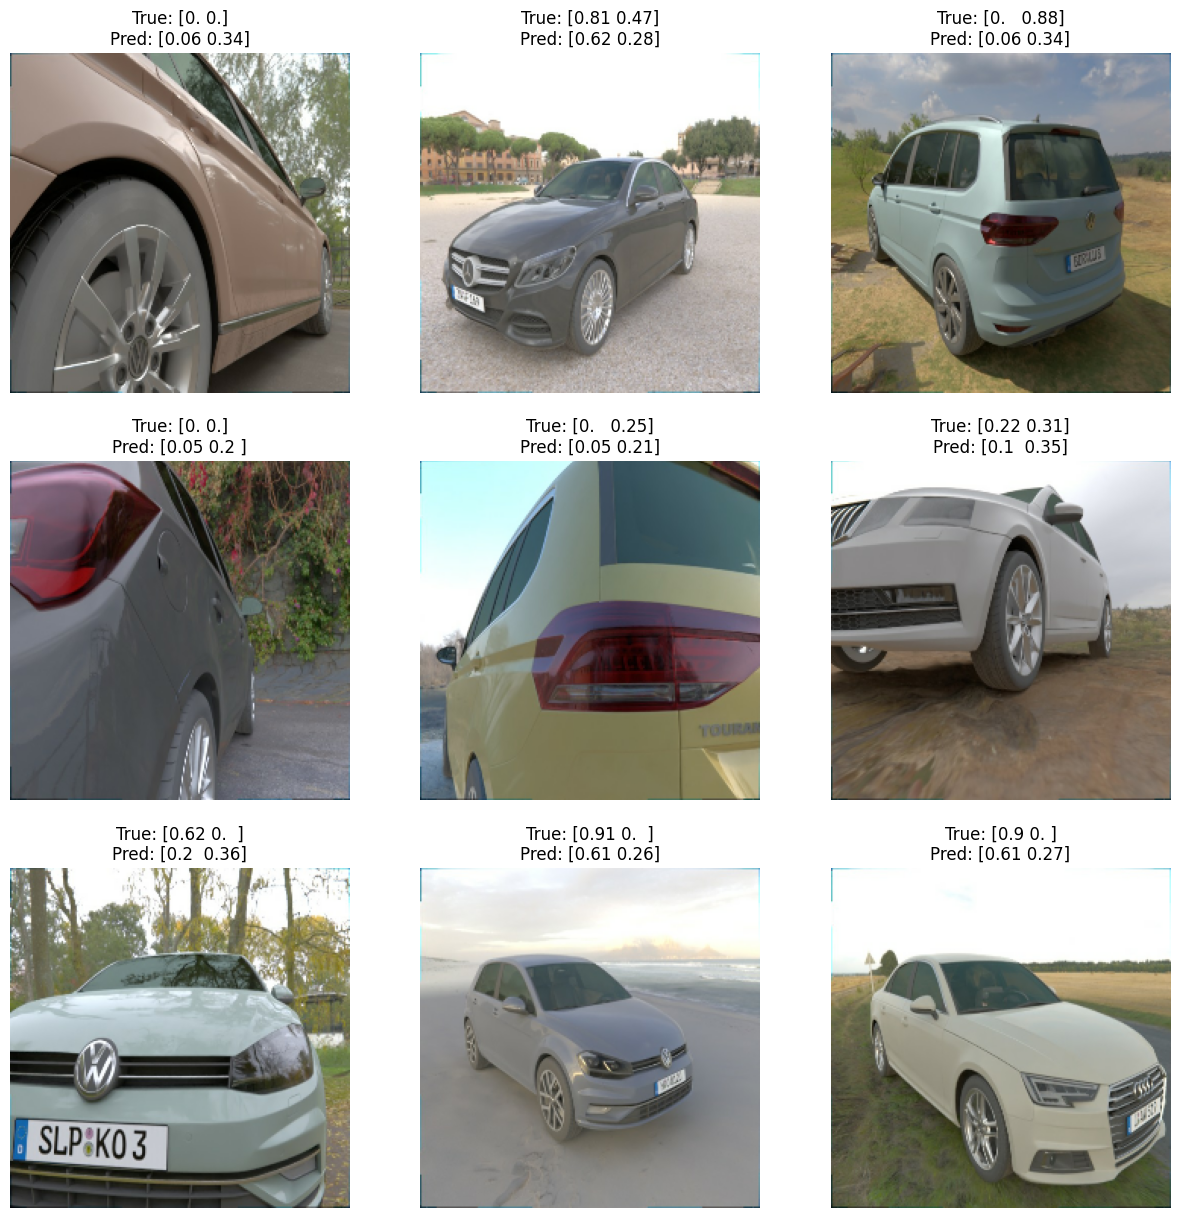

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_predictions(test_dataset, model, num_images=9):
    # Shuffle and take random images from the test dataset
    test_dataset = test_dataset.unbatch().shuffle(buffer_size=10000)  # Shuffle the dataset

    sampled_images = []
    sampled_labels = []

    # Collect the desired number of random images and labels
    for image, label in test_dataset.take(num_images):
        sampled_images.append(image.numpy())
        sampled_labels.append(label.numpy())
    
    # Convert the list to a numpy array for easier manipulation
    sampled_images = np.array(sampled_images)
    sampled_labels = np.array(sampled_labels)
    
    # Get predictions from the model
    predictions = model.predict(sampled_images)
    
    # Plotting the images and their predictions
    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(sampled_images[i])
        plt.title(f"True: {np.round(sampled_labels[i], 2)}\nPred: {np.round(predictions[i], 2)}")
        plt.axis('off')
    
    plt.show()

# Usage example
plot_random_predictions(test_dataset, model)

## Why not Transfer learning ? 

## [VGG16](https://arxiv.org/pdf/1409.1556v6) Architecture 
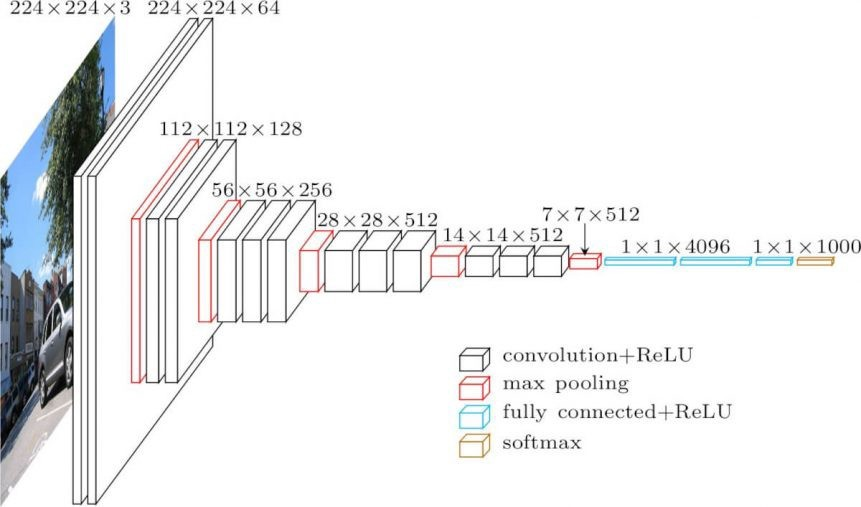

In [45]:
def build_model(input_shape: Tuple[int, int, int] = (224, 224, 3)) -> tf.keras.Model:
    
    # Load the VGG16 model, exclude the top fully connected layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of VGG16 model
    for layer in base_model.layers:
        layer.trainable = False
    # Add custom layers on top of the base model
    x = base_model.output # 7x7x512 
    
    x = GlobalAveragePooling2D()(x) ## 512 , could have flattened it but results into 7*7*512 -> large number of params 
    x = Dense(1024, activation='relu')(x) ## 1024 
    predictions = Dense(2, activation='sigmoid')(x)  # 2, Sigmoid ?? -> Not appropriate to predict close to 0 and 1 
    
    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model 

In [46]:
model = build_model()

In [47]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,242,050 (58.14 MB)

 Trainable params: 527,362 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [48]:
model_save_path = "./veihcle_pose_predictior_vgg16_sigmoid.keras"
callbacks = get_callbacks(model_save_path)

In [49]:
history = train_model(model, train_dataset_final, val_dataset, callbacks)

Epoch 1/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1290 - mae: 0.3150
Epoch 1: val_loss improved from inf to 0.08223, saving model to ./veihcle_pose_predictior_vgg16_sigmoid.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - loss: 0.1287 - mae: 0.3146 - val_loss: 0.0822 - val_mae: 0.2414
Epoch 2/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0829 - mae: 0.2346
Epoch 2: val_loss improved from 0.08223 to 0.06677, saving model to ./veihcle_pose_predictior_vgg16_sigmoid.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - loss: 0.0828 - mae: 0.2345 - val_loss: 0.0668 - val_mae: 0.2042
Epoch 3/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0683 - mae: 0.2041
Epoch 3: val_loss improved from 0.06677 to 0.05778, saving model to ./veihcle_pose_predictior_vgg16_sigmoid.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - loss: 0.0683 - mae: 0.2041 - val_loss: 0.0578 - val_mae: 0.1861
Epoch 4/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0567 - mae: 0.1810
Epoch 4: v

In [33]:
#dump_dict_vgg = save_dict_to_file(history, './vgg16_sig_history_dict')
history_loaded_vgg = load_dict_from_file('/kaggle/input/model-output/vgg16_sig_history_dict')

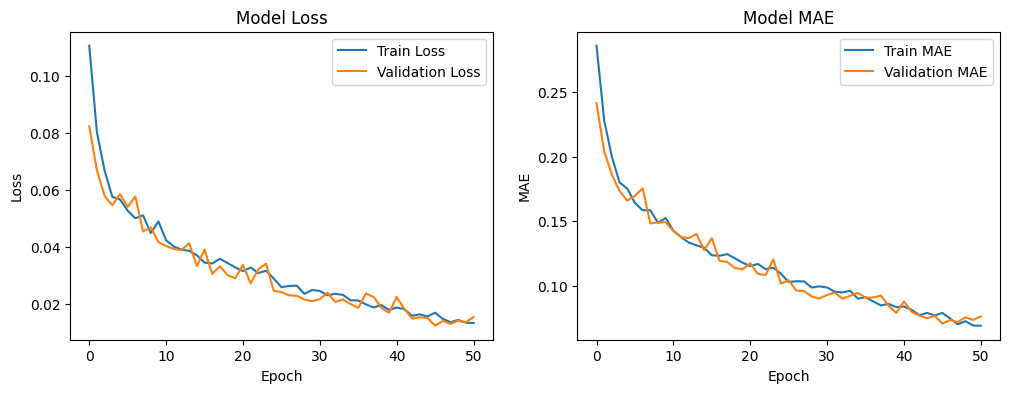

In [34]:
plot_training_history(history_loaded_vgg)

In [35]:
#model_save_path = "/kaggle/input/trained-model/veihcle_pose_predictior_vgg16.keras.keras"
model_save_path = "/kaggle/input/model-output/veihcle_pose_predictior_vgg16_sigmoid.keras"
model_loaded = load_trained_model(model_save_path)
model_loaded.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,296,776 (62.17 MB)

 Trainable params: 527,362 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 1,054,726 (4.02 MB)

In [36]:
model = model_loaded

In [37]:
test_loss, test_mae = evaluate_model_on_test(model, test_dataset) ## with vgg16 model 

I0000 00:00:1724833216.765611     108 service.cc:145] XLA service 0x7fa5d0045850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724833216.765675     108 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0207 - mae: 0.0911

I0000 00:00:1724833224.621074     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0199 - mae: 0.0879
Test Loss: 0.0192
Test MAE: 0.0860


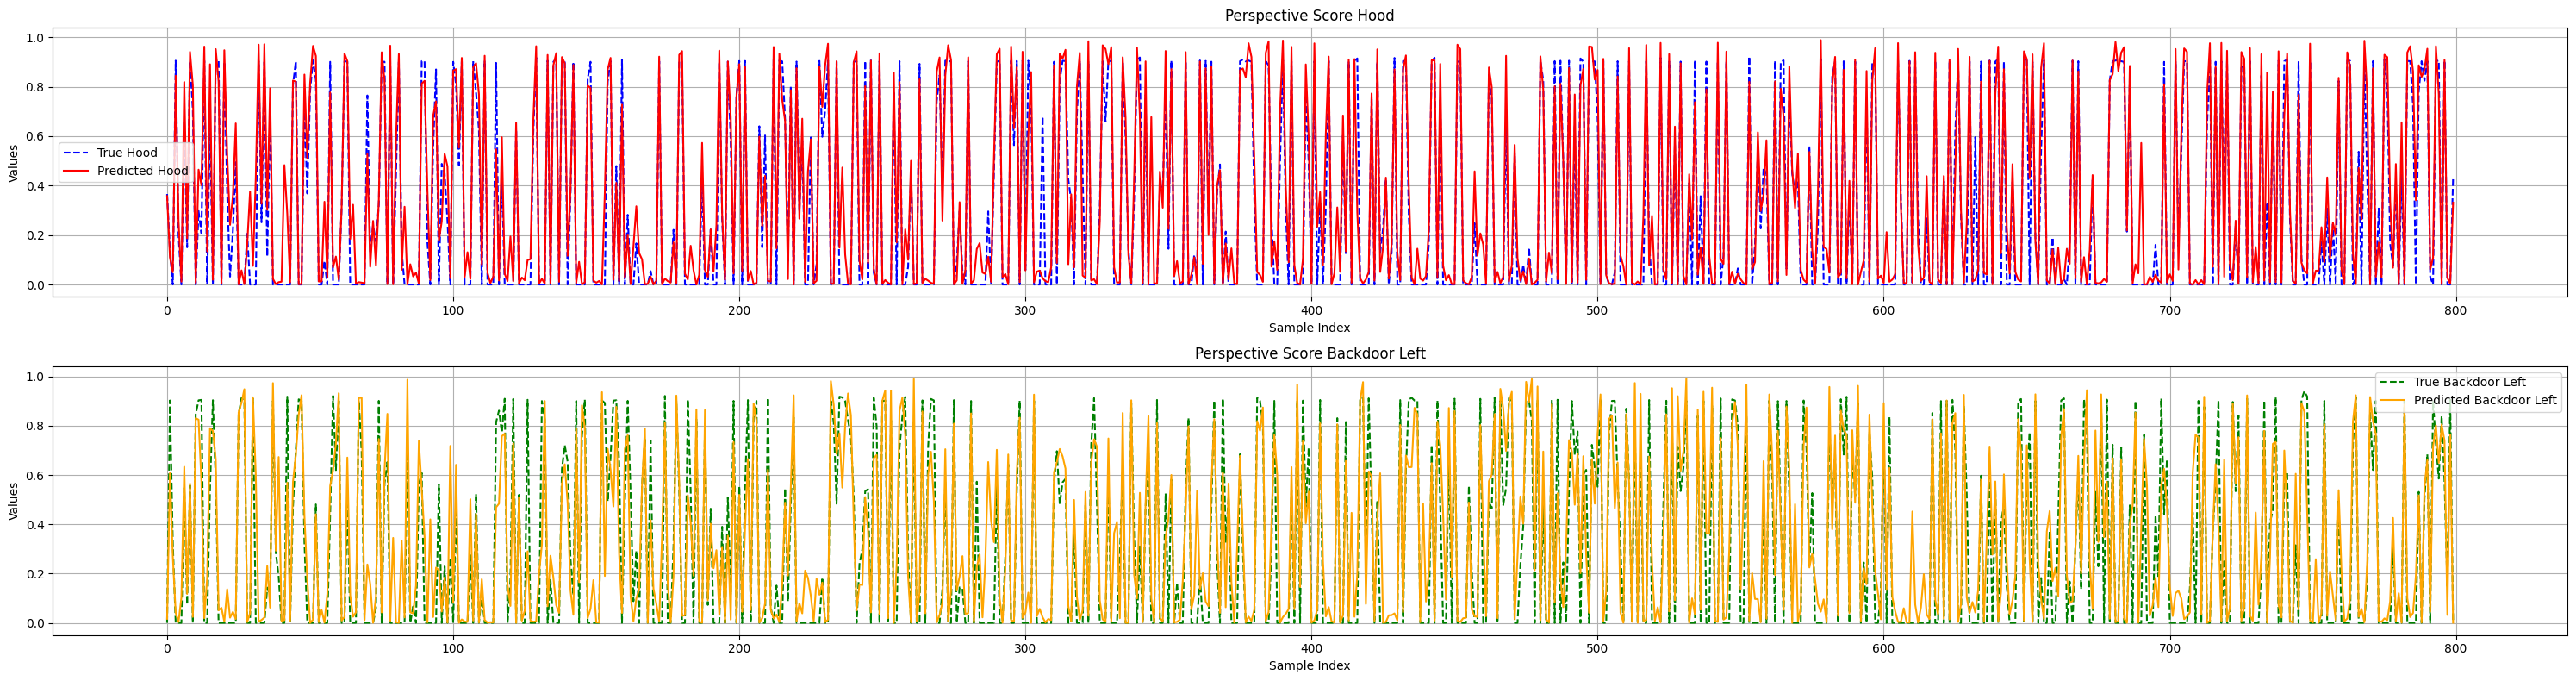

In [38]:
predictions, true_values = predict_on_test_set(model, test_dataset)
plot_predictions_vs_true_values(model, test_dataset)

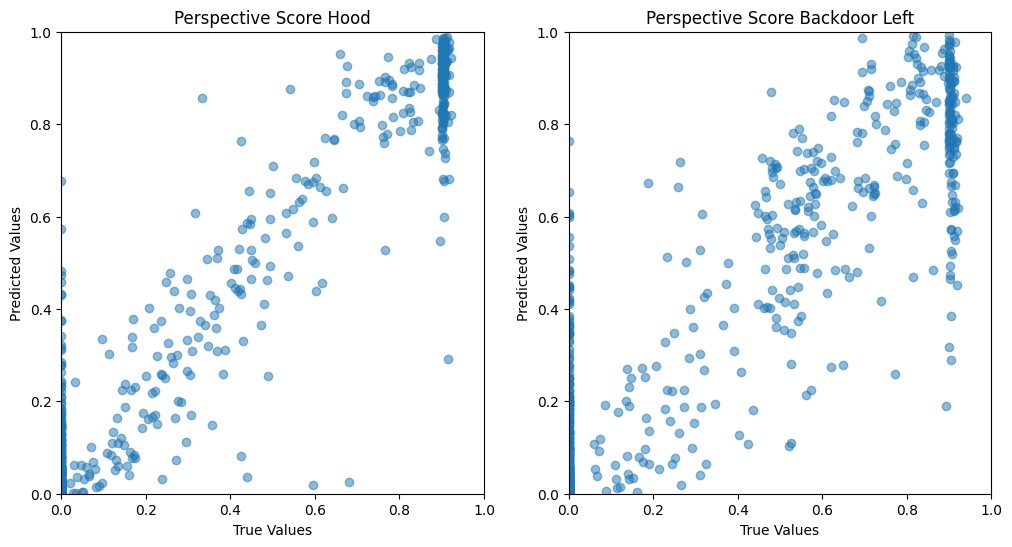

In [39]:
plot_predictions_vs_true(predictions, true_values)

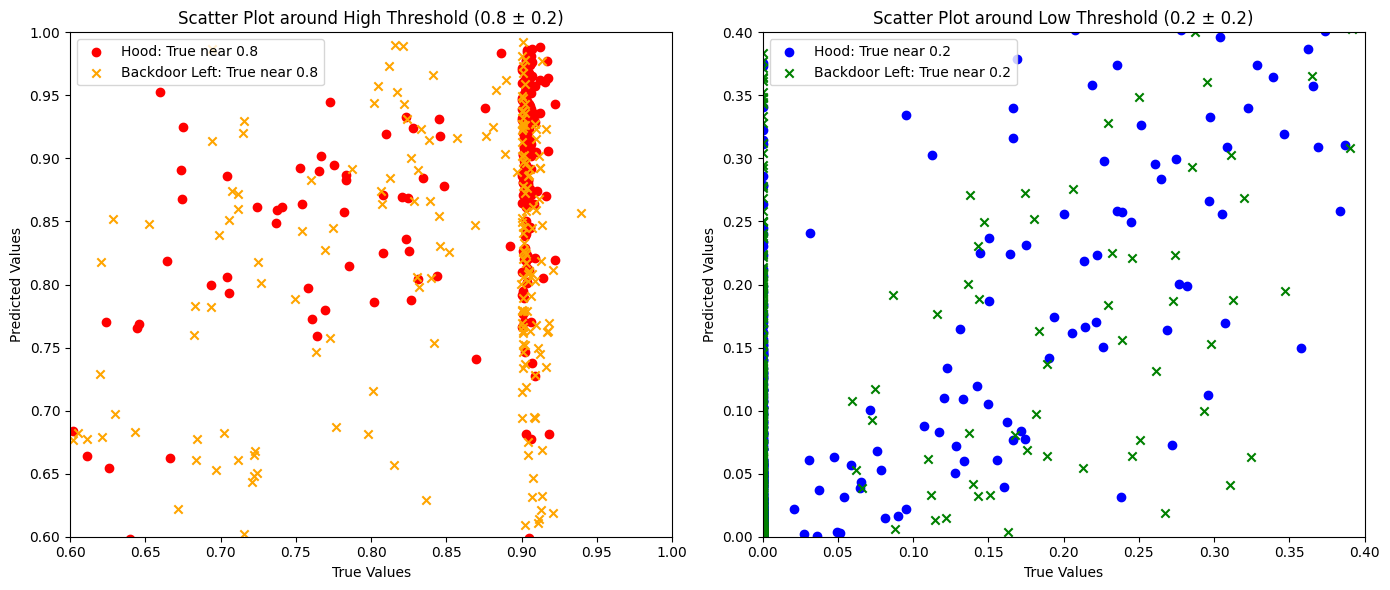

In [40]:
visualize_extreme_predictions(model, test_dataset, high_threshold=0.8, low_threshold=0.2, margin=0.2)

Mean Absolute Error Hood: 0.0649
Mean Absolute Error Backdoor Left: 0.1071


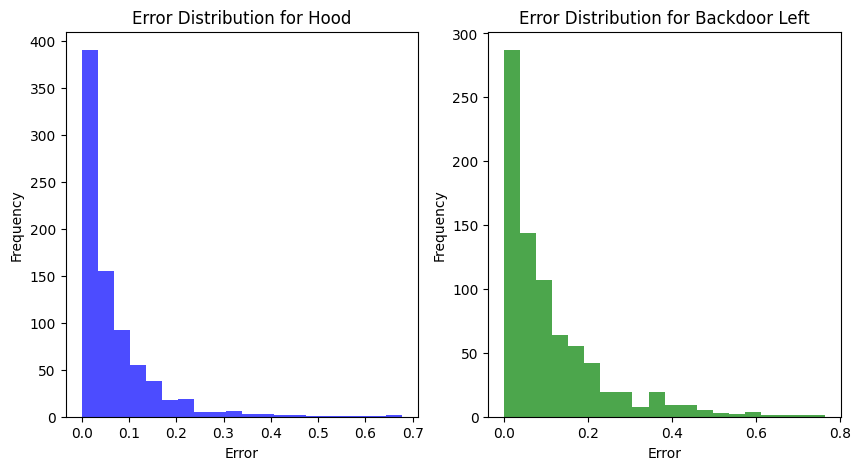

In [41]:
analyze_errors(predictions, true_values)

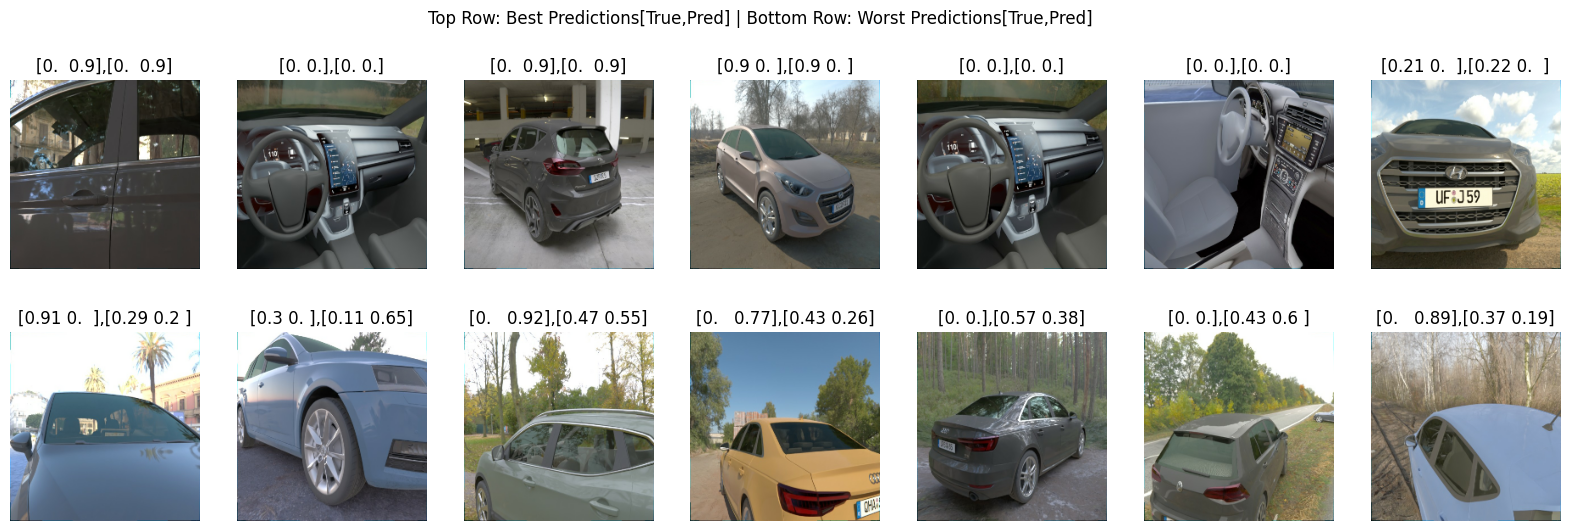

In [42]:
plot_best_and_worst_predictions(model, test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


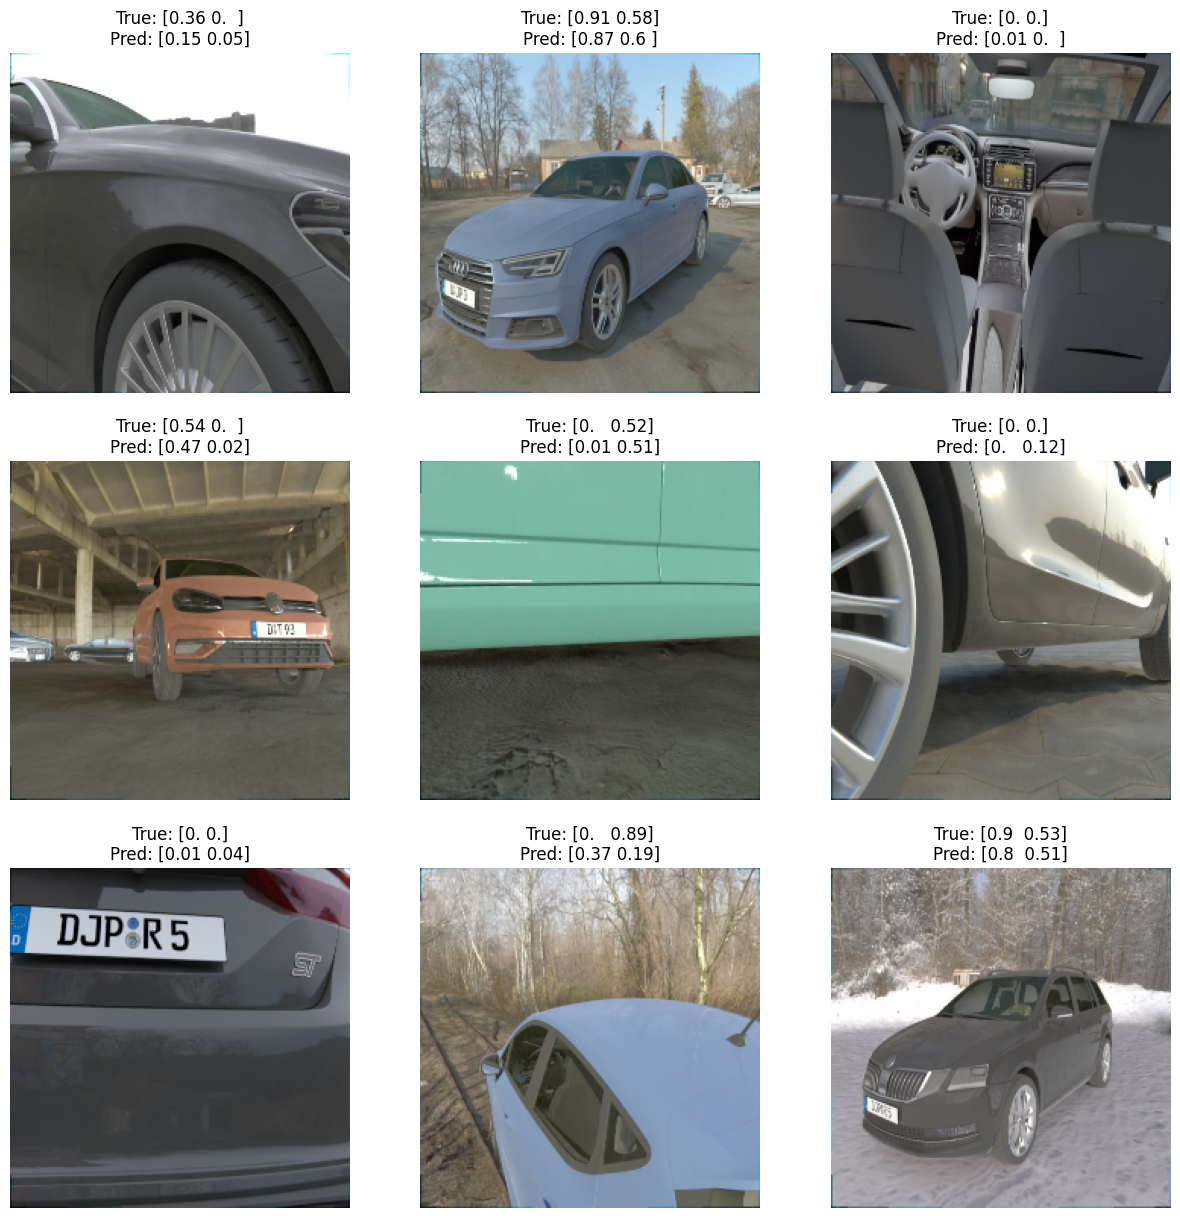

In [43]:
plot_random_predictions(test_dataset, model)

In [44]:
## Post processing 
import pandas as pd
import numpy as np

def create_predictions_csv(model, test_dataset, test_paths, output_csv_path):
    filenames = []
    predictions = []
    ground_truth = []

    # Iterate over the test dataset
    for (images, labels) in test_dataset:
        # Predict the scores
        preds = model.predict(images, verbose=0)

        # Collect the data
        predictions.extend(preds)
        ground_truth.extend(labels.numpy())

    # Since the dataset is batched, we need to flatten the filename list
    filenames = [os.path.basename(path) for path in test_paths]

    # Create a DataFrame
    df = pd.DataFrame({
        'filename': filenames,
        'ground_truth_score_hood': [g[0] for g in ground_truth],
        'predicted_score_hood': [p[0] for p in predictions],
        'ground_truth_score_backdoor_left': [g[1] for g in ground_truth],
        'predicted_score_backdoor_left': [p[1] for p in predictions]
    })

    # Save the DataFrame to a CSV file
    df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")
    return df 

output_csv_path = 'predictions.csv'
df = create_predictions_csv(model, test_dataset, test_paths, output_csv_path)

Predictions saved to predictions.csv


In [45]:
df.head()

filename  ground_truth_score_hood  \
0  631acb37-453d-439f-8864-0e03a3a81536.jpg                 0.365978   
1  a436a18b-13bc-4990-98b1-5b15eb21bd75.jpg                 0.133025   
2  082e3663-9fd9-4c45-9922-945aeaa6b41d.jpg                 0.000000   
3  4d4c13ef-402f-49ad-ac8a-0b8a1ff75e34.jpg                 0.905469   
4  ede78ad5-c986-444a-ae3f-4b435595da8c.jpg                 0.200486   

   predicted_score_hood  ground_truth_score_backdoor_left  \
0              0.357808                          0.000000   
1              0.108909                          0.902524   
2              0.049953                          0.319938   
3              0.844482                          0.000000   
4              0.255879                          0.000000   

   predicted_score_backdoor_left  
0                       0.016411  
1                       0.608907  
2                       0.268455  
3                       0.040346  
4                       0.003714

In [46]:
df.describe()

ground_truth_score_hood  predicted_score_hood  \
count               800.000000            800.000000   
mean                  0.314755              0.347948   
std                   0.386670              0.380362   
min                   0.000000              0.000005   
25%                   0.000000              0.015701   
50%                   0.000000              0.126721   
75%                   0.807963              0.807236   
max                   0.922428              0.988477   

       ground_truth_score_backdoor_left  predicted_score_backdoor_left  
count                        800.000000                     800.000000  
mean                           0.308142                       0.339366  
std                            0.368174                       0.334137  
min                            0.000000                       0.000065  
25%                            0.000000                       0.027193  
50%                            0.000000                       0.194204  
75%                            0.665382                       0.661530  
max                            0.939541                       0.992009

### **Root Mean Squared Error (RMSE)**:
   - RMSE provides a straightforward measure of error in the same units as the target variable. It gives more weight to larger errors, which can be useful if you want to penalize larger deviations more strongly.

In [47]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_hood = np.sqrt(mean_squared_error(true_values[:, 0], predictions[:, 0]))
rmse_backdoor_left = np.sqrt(mean_squared_error(true_values[:, 1], predictions[:, 1]))

print(f"RMSE for Hood: {rmse_hood:.4f}")
print(f"RMSE for Backdoor Left: {rmse_backdoor_left:.4f}")

RMSE for Hood: 0.1094
RMSE for Backdoor Left: 0.1625


### 1. **R-Squared (\( R^2 \))**:
   - \( R^2 \) gives a measure of how well your model explains the variance in the data. Values range from 0 to 1, with higher values indicating a better fit. This metric is less sensitive to the issues that affect SMAPE.
   

In [48]:
from sklearn.metrics import r2_score

r2_hood = r2_score(true_values[:, 0], predictions[:, 0])
r2_backdoor_left = r2_score(true_values[:, 1], predictions[:, 1])

print(f"R² for Hood: {r2_hood:.4f}")
print(f"R² for Backdoor Left: {r2_backdoor_left:.4f}")

R² for Hood: 0.9199
R² for Backdoor Left: 0.8048


### 3. **Max Error**:
   - The max error metric shows the largest deviation between the predicted and actual values. It’s particularly useful for understanding the worst-case performance of your model.

In [49]:
from sklearn.metrics import max_error

max_error_hood = max_error(true_values[:, 0], predictions[:, 0])
max_error_backdoor_left = max_error(true_values[:, 1], predictions[:, 1])

print(f"Max Error for Hood: {max_error_hood:.4f}")
print(f"Max Error for Backdoor Left: {max_error_backdoor_left:.4f}")

Max Error for Hood: 0.6773
Max Error for Backdoor Left: 0.7633


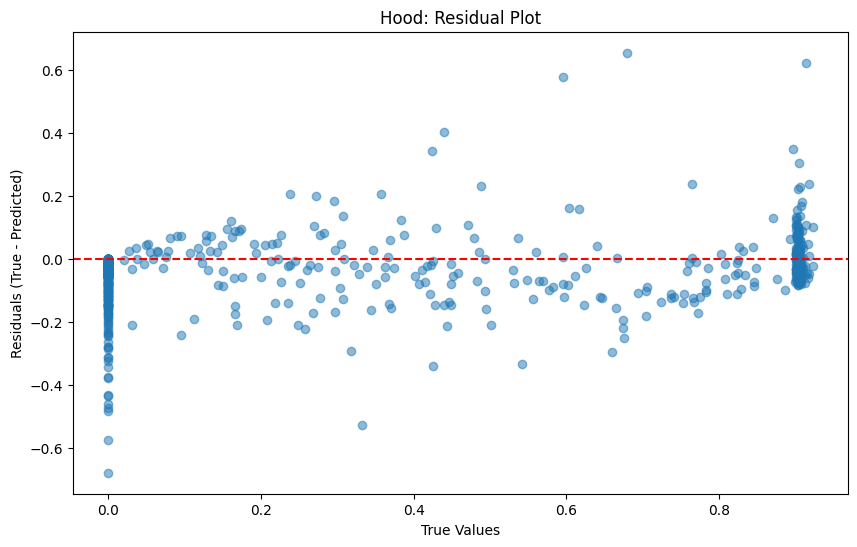

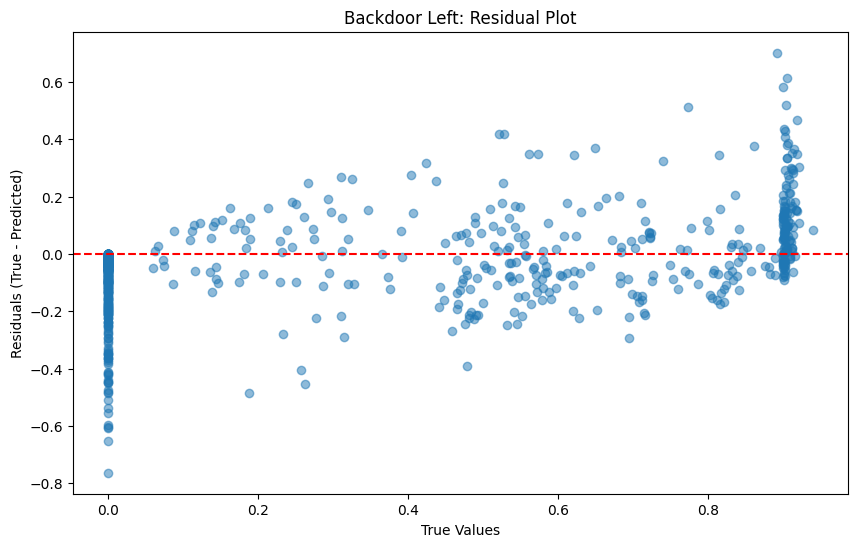

In [50]:
import matplotlib.pyplot as plt

def plot_residuals(y_true, y_pred, title="Residual Plot"):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('True Values')
    plt.ylabel('Residuals (True - Predicted)')
    plt.title(title)
    plt.show()

# Example usage:
plot_residuals(true_values[:, 0], predictions[:, 0], title="Hood: Residual Plot")
plot_residuals(true_values[:, 1], predictions[:, 1], title="Backdoor Left: Residual Plot")
